In [177]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
sns.set()

In [178]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        backward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        forward_rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        drop_backward = tf.contrib.rnn.DropoutWrapper(
            backward_rnn_cells, output_keep_prob = forget_bias
        )
        forward_backward = tf.contrib.rnn.DropoutWrapper(
            forward_rnn_cells, output_keep_prob = forget_bias
        )
        self.backward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        self.forward_hidden_layer = tf.placeholder(
            tf.float32, shape = (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.bidirectional_dynamic_rnn(
            forward_backward,
            drop_backward,
            self.X,
            initial_state_fw = self.forward_hidden_layer,
            initial_state_bw = self.backward_hidden_layer,
            dtype = tf.float32,
        )
        self.outputs = tf.concat(self.outputs, 2)
        rnn_W = tf.Variable(tf.random_normal((size_layer * 2, output_size)))
        rnn_B = tf.Variable(tf.random_normal([output_size]))
        self.logits = tf.matmul(self.outputs[-1], rnn_W) + rnn_B
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )


In [179]:
df = pd.read_csv('../dataset/TOT-year.csv')
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-08,56.130001,56.330002,54.599998,54.619999,51.336739,3572800
1,2018-02-09,55.290001,55.639999,53.369999,55.000000,51.693897,2100300
2,2018-02-12,55.520000,56.020000,55.389999,55.720001,52.370617,1383000
3,2018-02-13,56.240002,56.470001,56.020000,56.040001,52.671383,1596200
4,2018-02-14,55.369999,57.169998,55.299999,57.130001,53.695866,1109600


In [180]:
minmax = MinMaxScaler().fit(df.iloc[:, 1:].astype('float32'))
df_log = minmax.transform(df.iloc[:, 1:].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

,0,1,2,3,4,5
0,0.382295,0.321739,0.317357,0.289093,0.122208,0.340864
1,0.327213,0.271739,0.237694,0.314060,0.147380,0.178424
2,0.342295,0.299275,0.368523,0.361367,0.195073,0.099295
3,0.389508,0.331884,0.409326,0.382392,0.216270,0.122814
4,0.332459,0.382609,0.362694,0.454008,0.288473,0.069135


In [181]:
num_layers = 1
size_layer = 16
timestamp = 5
epoch = 200
dropout_rate = 0.6
future_day = 60

In [182]:
tf.reset_default_graph()
modelnn = Model(0.002, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [183]:
for i in range(epoch):
    init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
    init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    for k in range(0, df_log.shape[0] - 1, timestamp):
        index = min(k + timestamp, df_log.shape[0] - 1)
        batch_x = np.expand_dims(
            df_log.iloc[k : index, :].values, axis = 0
        )
        batch_y = df_log.iloc[k + 1 : index + 1, :].values
        last_state, _, loss = sess.run(
            [modelnn.last_state, modelnn.optimizer, modelnn.cost],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y,
                modelnn.backward_hidden_layer: init_value_backward,
                modelnn.forward_hidden_layer: init_value_forward,
            },
        )
        init_value_forward = last_state[0]
        init_value_backward = last_state[1]
        total_loss += loss
    total_loss /= df_log.shape[0] // timestamp
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)


epoch: 100 avg loss: 0.00631984533626
epoch: 200 avg loss: 0.00523663041531


In [184]:
output_predict = np.zeros((df_log.shape[0] + future_day, df_log.shape[1]))
output_predict[0, :] = df_log.iloc[0, :]
upper_b = (df_log.shape[0] // timestamp) * timestamp
init_value_forward = np.zeros((1, num_layers * 2 * size_layer))
init_value_backward = np.zeros((1, num_layers * 2 * size_layer))
for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(
                df_log.iloc[k : k + timestamp, :], axis = 0
            ),
            modelnn.backward_hidden_layer: init_value_backward,
            modelnn.forward_hidden_layer: init_value_forward,
        },
    )
    init_value_forward = last_state[0]
    init_value_backward = last_state[1]
    output_predict[k + 1 : k + timestamp + 1, :] = out_logits

out_logits, last_state = sess.run(
    [modelnn.logits, modelnn.last_state],
    feed_dict = {
        modelnn.X: np.expand_dims(df_log.iloc[upper_b:, :], axis = 0),
        modelnn.backward_hidden_layer: init_value_backward,
        modelnn.forward_hidden_layer: init_value_forward,
    },
)
init_value_forward = last_state[0]
init_value_backward = last_state[1]
output_predict[upper_b + 1 : df_log.shape[0] + 1, :] = out_logits
df_log.loc[df_log.shape[0]] = out_logits[-1, :]
date_ori.append(date_ori[-1] + timedelta(days = 1))


In [185]:
for i in range(future_day - 1):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df_log.iloc[-timestamp:, :], axis = 0),
            modelnn.backward_hidden_layer: init_value_backward,
            modelnn.forward_hidden_layer: init_value_forward,
        },
    )
    init_value_forward = last_state[0]
    init_value_backward = last_state[1]
    output_predict[df_log.shape[0], :] = out_logits[-1, :]
    df_log.loc[df_log.shape[0]] = out_logits[-1, :]
    date_ori.append(date_ori[-1] + timedelta(days = 1))

In [186]:
df_log = minmax.inverse_transform(output_predict)
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()

In [187]:
df= pd.read_csv('../dataset/TOT-year-now.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-08,56.130001,56.330002,54.599998,54.619999,51.336739,3572800
1,2018-02-09,55.290001,55.639999,53.369999,55.000000,51.693897,2100300
2,2018-02-12,55.520000,56.020000,55.389999,55.720001,52.370617,1383000
3,2018-02-13,56.240002,56.470001,56.020000,56.040001,52.671383,1596200
4,2018-02-14,55.369999,57.169998,55.299999,57.130001,53.695866,1109600


In [188]:
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

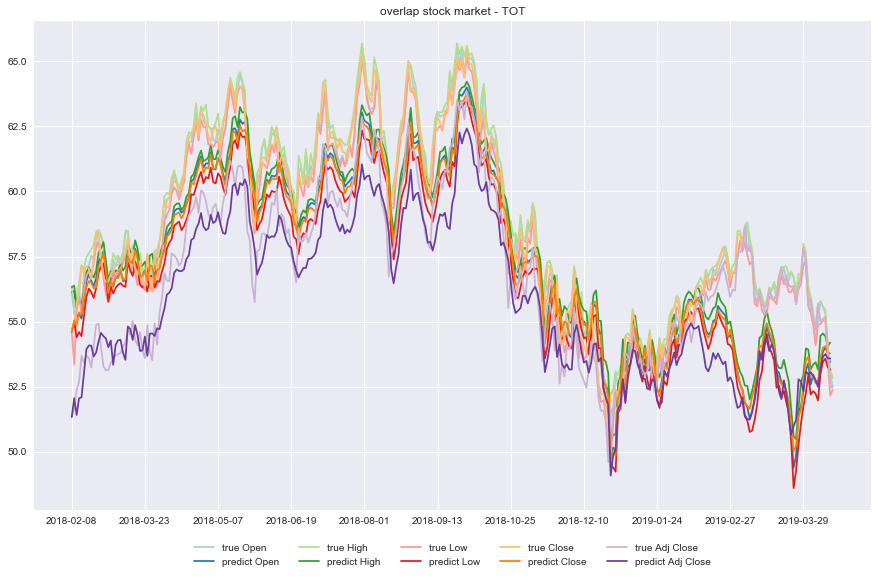

In [189]:
current_palette = sns.color_palette('Paired', 12)
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
x_range_original = np.arange(df.shape[0])
x_range_future = np.arange(df_log.shape[0])
ax.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Open',
    color = current_palette[0],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 0], 0.5),
    label = 'predict Open',
    color = current_palette[1],
)
ax.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true High',
    color = current_palette[2],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 1], 0.5),
    label = 'predict High',
    color = current_palette[3],
)
ax.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true Low',
    color = current_palette[4],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 2], 0.5),
    label = 'predict Low',
    color = current_palette[5],
)
ax.plot(
    x_range_original,
    df.iloc[:, 4],
    label = 'true Close',
    color = current_palette[6],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 3], 0.5),
    label = 'predict Close',
    color = current_palette[7],
)
ax.plot(
    x_range_original,
    df.iloc[:, 5],
    label = 'true Adj Close',
    color = current_palette[8],
)
ax.plot(
    x_range_future,
    anchor(df_log[:, 4], 0.5),
    label = 'predict Adj Close',
    color = current_palette[9],
)
box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.title('overlap stock market - TOT')
plt.xticks(x_range_future[::30], date_ori[::30])
plt.show()

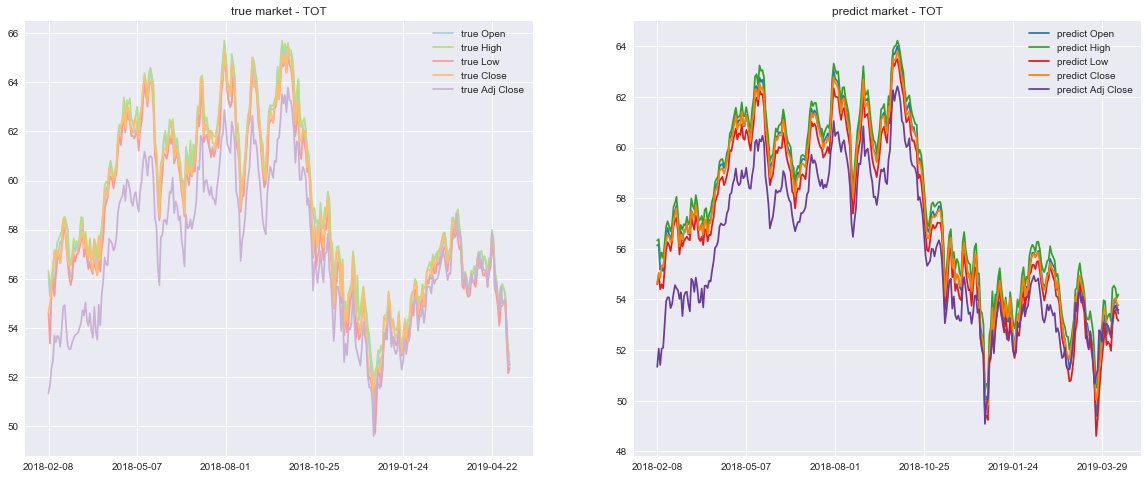

In [190]:
fig = plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Open',
    color = current_palette[0],
)
plt.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true High',
    color = current_palette[2],
)
plt.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true Low',
    color = current_palette[4],
)
plt.plot(
    x_range_original,
    df.iloc[:, 4],
    label = 'true Close',
    color = current_palette[6],
)
plt.plot(
    x_range_original,
    df.iloc[:, 5],
    label = 'true Adj Close',
    color = current_palette[8],
)
plt.xticks(x_range_original[::60], df.iloc[:, 0].tolist()[::60])
plt.legend()
plt.title('true market - TOT')
plt.subplot(1, 2, 2)
plt.plot(
    x_range_future,
    anchor(df_log[:, 0], 0.5),
    label = 'predict Open',
    color = current_palette[1],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 1], 0.5),
    label = 'predict High',
    color = current_palette[3],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 2], 0.5),
    label = 'predict Low',
    color = current_palette[5],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 3], 0.5),
    label = 'predict Close',
    color = current_palette[7],
)
plt.plot(
    x_range_future,
    anchor(df_log[:, 4], 0.5),
    label = 'predict Adj Close',
    color = current_palette[9],
)
plt.xticks(x_range_future[::60], date_ori[::60])
plt.legend()
plt.title('predict market - TOT')
plt.show()

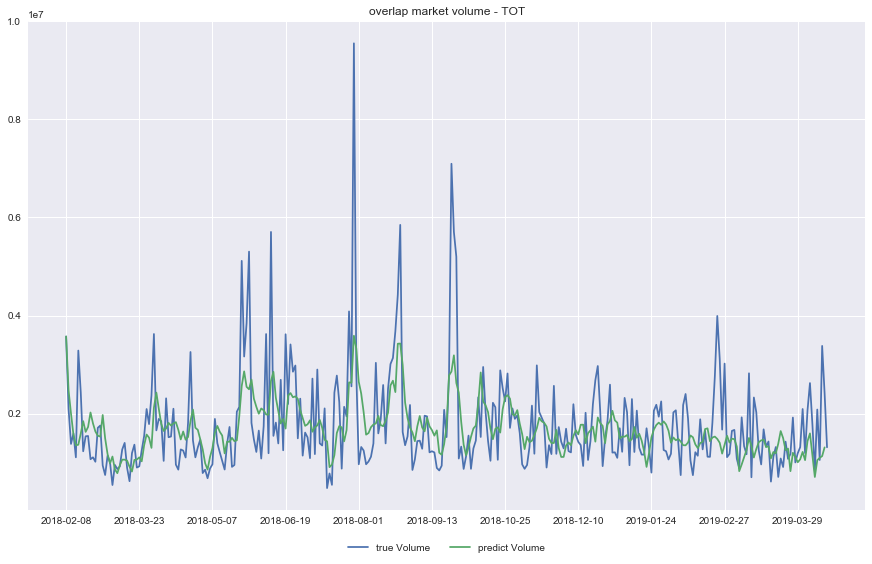

In [191]:
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
ax.plot(x_range_original, df.iloc[:, -1], label = 'true Volume')
ax.plot(x_range_future, anchor(df_log[:, -1], 0.5), label = 'predict Volume')
box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.xticks(x_range_future[::30], date_ori[::30])
plt.title('overlap market volume - TOT')
plt.show()

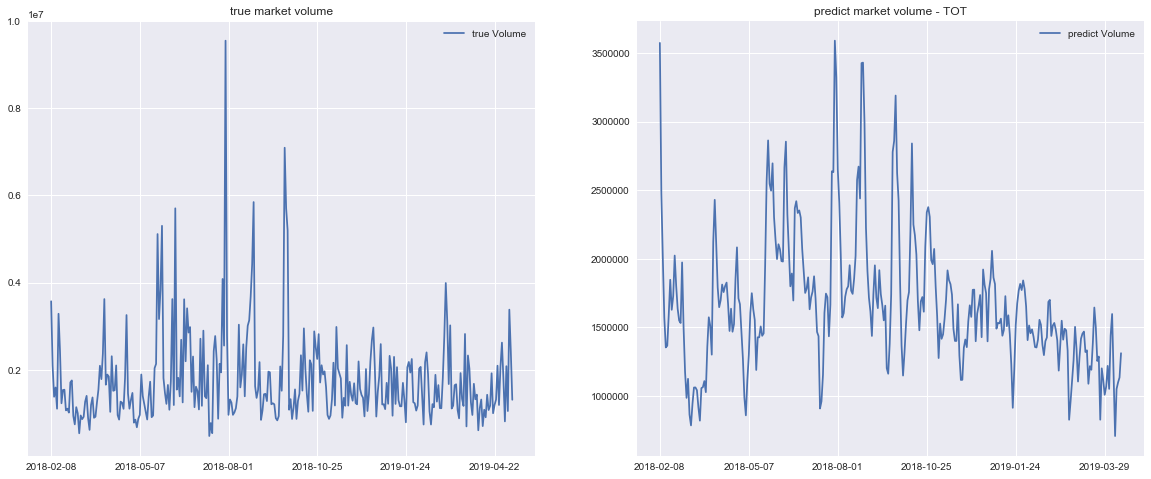

In [192]:
fig = plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(x_range_original, df.iloc[:, -1], label = 'true Volume')
plt.xticks(x_range_original[::60], df.iloc[:, 0].tolist()[::60])
plt.legend()
plt.title('true market volume')
plt.subplot(1, 2, 2)
plt.plot(x_range_future, anchor(df_log[:, -1], 0.5), label = 'predict Volume')
plt.xticks(x_range_future[::60], date_ori[::60])
plt.legend()
plt.title('predict market volume - TOT')
plt.show()